In [1]:
import os
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib
from scipy import fftpack as spfft # for computing spectra
import scipy.signal as spsig
from scipy.io.wavfile import write

import resampy
from subprocess import call

import IPython.display as ipd

%matplotlib inline

# Set plot fontsize
matplotlib.rcParams.update({"font.size": 14})

%config InlineBackend.figure_formats = ["svg"]

Direct sonification is simply the process of changing the time scale of a signal to transpose it to the audible range. The data should therefore have similarities with sound waves in air, that is:

 - oscillations around an average value (better if this value is 0), a.k.a "stationary" data. 
 - not a vast range of amplitudes in the thing of interest
 - enough cycles to produce sound at the new frequency. 

We take the example of seismic data... but they could be many other things, e.g.:

[planetary:] 

 - ocean waves, tidal data
 - electro-magnetic waves (solar winds?)
 - gravitational waves
 - planetary orbital positions
 
[biological:] 

 - blood pressure
 - ekg brain waves
 
[sociological:] 
 - stock markets (detrended)?  

# EXAMPLE 1: a large earthquake 


## 1. Get the data (and in to python):

In [2]:
DirIn = os.path.join(os.pardir, "data_nogit", "seismic_data")
DirOut = os.path.join(os.pardir, "output_nogit")

# (get the data first from the google drive for class-- and put it in the DirIn )
# This is the Tohoku earthquake (2011), recorded by a seimic station located in Central USA
FileNameIn = "P39A.BHZ"  # Note that this data has been pre-processed (instrument response removal)
fs = 20  # Datatype BHZ is sampled at 20 Hz
# In this case, you need to get the info from the data source. )

data = np.loadtxt(os.path.join(DirIn, FileNameIn))
duration = len(data) / fs
print(f"We have {len(data)} data points at a sampling frequency fs of {fs:.0f}Hz.")
print(f"We have {int(duration)} seconds of data!")
print(f"... which is {duration / 3600.:.1f} hours of data!")

# make time vectors for plotting purposes only
t = np.arange(0, duration, 1.0 / fs)  # in seconds
t_hours = np.arange(0, duration / 3600, 1.0 / fs / 3600)  # in hours


We have 1008000 data points at a sampling frequency fs of 20Hz.
We have 50400 seconds of data!
... which is 14.0 hours of data!


In [3]:
# Compute the spectrum

###### some useful prerequisites...

# 1) force the signal's mean value to be zero (to protect your loudspeakers...)
data = data - np.mean(data)

# 2) limit the signal's amplitude = avoid too large peaks (how to re-kill your loudspeakers...)
# a simple way is to normalize the data according to its maximum amplitude value
# data = data/np.amax(data) # This is dangerous, peak values can be negative, too
# better to do it THIS way:  
data_n = data/np.amax(data)


S = spfft.rfft(data, len(data))
f = spfft.rfftfreq(len(data), d=1./fs)
#https://en.wikipedia.org/wiki/Nyquist_frequency

print(f"Frequency content ranges from {f[0]:.2e}Hz to {f[-1]:.2f}Hz... (Nyquist frequency)")
print(f"Log frequency content ranges from {np.log10(f[1]):.2f}[log10(Hz)] to {np.log10(f[-1]):.2f}[log10(Hz)]")

Frequency content ranges from 0.00e+00Hz to 10.00Hz... (Nyquist frequency)
Log frequency content ranges from -4.70[log10(Hz)] to 1.00[log10(Hz)]


[]

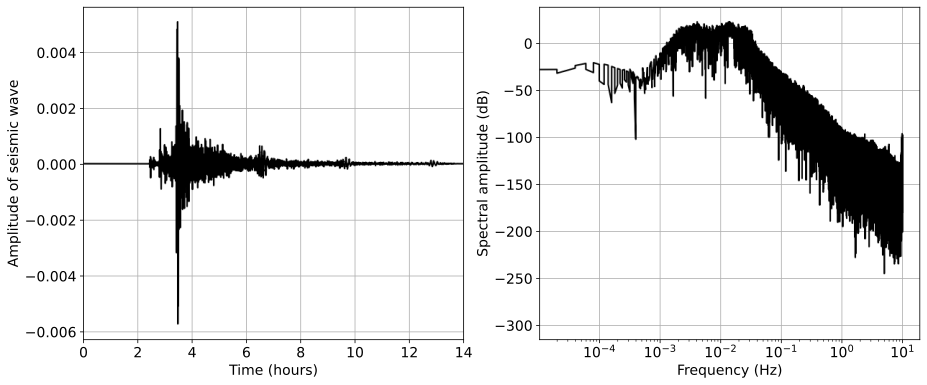

In [4]:
# waveform
fig, axes = plt.subplots(num="Tohoku_time_vs_spectral_domain", ncols=2, figsize=(15, 6))

axes[0].plot(t_hours, data, "k", rasterized=True)
axes[0].set_xlabel("Time (hours)")
axes[0].set_ylabel("Amplitude of seismic wave")
axes[0].grid()
axes[0].set_xlim([0, duration / 3600])

# spectrum:

# plt.plot(f,20*np.log10(np.absolute(S)),'k')
axes[1].plot(f, 20 * np.log10(np.abs(S)), "k", rasterized=True)
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Spectral amplitude (dB)")
axes[1].grid()
axes[1].semilogx()
# axes[1].axis()


In [5]:
# SPECTROGRAM !
# first compute the short time fourier transform STFT
# or
duration = len(data) / fs
numwindows = 1000
WindowDur = duration / numwindows


WindowLength = int(
    WindowDur * fs
)  # [s] The length of each frame (should be expressed in samples)
# does this need to be a power of 2 ?  apparently not ! (it could be to make it faster)

print(f"Window duration in seconds: {WindowDur:.2f}sec.")
print(f"Window length in samples: {WindowLength:d}spl.")

# Window overlap: The overlapping between successive frames (should be expressed in samples)
# This changes the total number of windows, but has to be smaller than the window length (in samples)
# Eric says the optimal is the number of points - 1 ! (not necessarily, I just said that for the specific application with SpecUFEX)
# Overlap = int(WindowLength/2)  # 50% overlap:  quick but has some aliasing/artifacts
# Overlap = int(WindowLength-1)  # length - 1 !  TOO much for this machine!
Overlap = int(0.5 * WindowLength)

[fSTFT, tSTFT, STFT] = spsig.spectrogram(
    data_n, fs, nperseg=WindowLength, noverlap=Overlap,
)
# also provides associated f and t vectors!
print(f"The frequency axis has {len(fSTFT):d} elements, ranging from {fSTFT.min():.2e}Hz to {fSTFT.max():.2f}Hz.")
print(f"The time axis has {len(tSTFT):d} elements, ranging from {tSTFT.min()}s to {tSTFT.max()}s.")
print(f"The shape of the STFT matrix is: {STFT.shape}")


Window duration in seconds: 50.40sec.
Window length in samples: 1008spl.
The frequency axis has 505 elements, ranging from 0.00e+00Hz to 10.00Hz.
The time axis has 1999 elements, ranging from 25.2s to 50374.8s.
The shape of the STFT matrix is: (505, 1999)


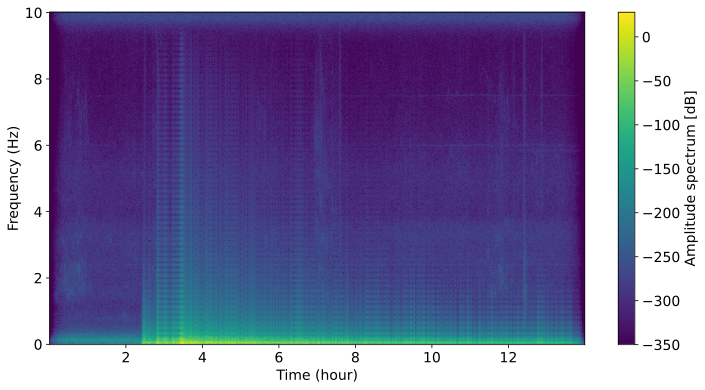

In [6]:
# Let's plot the spectrogram
# notice that the y-axis goes up to half of fs ! i.e. Nyquist frequency
fig, ax = plt.subplots(figsize=(12, 6))
pc = ax.pcolormesh(
    tSTFT/3600., fSTFT, 20 * np.log10(np.absolute(STFT)), rasterized=True, vmin=-350
)  # dB = 20*log() is a convention
# ax.set_ylim([0, fs/8])
ax.set_xlabel("Time (hour)")
ax.set_ylabel("Frequency (Hz)")
cbar = plt.colorbar(pc, label="Amplitude spectrum [dB]")
# try with frequency in log scale:
# ax.semilogy()
# ax.set_ylim(0.001, 10.)


In [27]:
# Future: Make a separate Librosa notebook! 
# Now make a spectrogram with Librosa ! 
# https://librosa.github.io/librosa/generated/librosa.display.specshow.html

# FIRST compute the short time fourier transform: 
#data_stft = librosa.core.stft(y, n_fft=2048, hop_length=None, win_length=None, window='hann', center=True, 
#                              dtype=<class 'numpy.complex64'>, pad_mode='reflect')[source]

# THEN display it: 
# librosa.display.specshow(data, x_coords=None, y_coords=None, x_axis=None, y_axis=None, sr=22050, hop_length=512, 
# fmin=None, fmax=None, tuning=0.0, bins_per_octave=12, ax=None, **kwargs)[source]
# print(data_n.shape)
# data_stft = np.abs(librosa.stft(data_n, n_fft=int(len(data_n)/1000)) )
# data_stft_l10 = 20*np.log10(data_stft)
# data_stft_db = librosa.amplitude_to_db(data_stft,ref=np.max)
# librosa.display.specshow(data_stft_l10, sr=fs) #, y_axis='log', x_axis='time'


## NOW MAKE SOUND !

In [7]:
OutFileName = FileNameIn[:-4] + "_sonified.wav"

# For the free oscillations, we had a specific frequency that we wanted to shift to another one
# Here we can define a target duration instead

OriginalDuration = duration
TargetDuration = 3.0  # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print(f"The data is {OriginalDuration:.0f}-second long.")
print(f"Let's make a {TargetDuration:.0f}-second long sound!")

SpeedFactor = OriginalDuration / TargetDuration
print(f"This corresponds to a speed factor of: {SpeedFactor:.0f}.")

# (here we are speeding up the playback because the original content is infrasonic /
# There are cases where we want to do the opposite, e.g. solar magnetic waves, acoustic emissions during rock microcracking...)
# compute the corresponding shift in frequency
# show the result with subplots original data VS. sonified data
#      (time series / spectrum / spectrogram = no change except in the time scale)


The data is 50400-second long.
Let's make a 3-second long sound!
This corresponds to a speed factor of: 16800.


In [8]:
# So, set the new sampling rate, and then resample to a standard sampling rate
fs_sound = int(fs*SpeedFactor)
#sr_resample = 44100

#librosa.output.write_wav(DirOut + OutFileName, data_n, 4*fs_sound, norm=False)

# Some software have troubles with exotic sampling rates (VLC and audacity don't have), so it might be necessary 
# to resample your sound.
#dataOrig, srOrig = librosa.core.load(DirOut + OutFileName, sr=sr_sound)
#data_rs = resampy.resample(dataOrig, srOrig, sr_resample)
#librosa.output.write_wav(DirOut + OutFileName, data_rs, sr_resample, norm=False)

print(f"We are generating a sound with sampling frequency fs={fs_sound:.0f}Hz.")

ipd.Audio(data_n, rate=fs_sound) 

We are generating a sound with sampling frequency fs=336000Hz.


1008000 132300
We are generating a sound with sampling frequency fs=44100Hz.


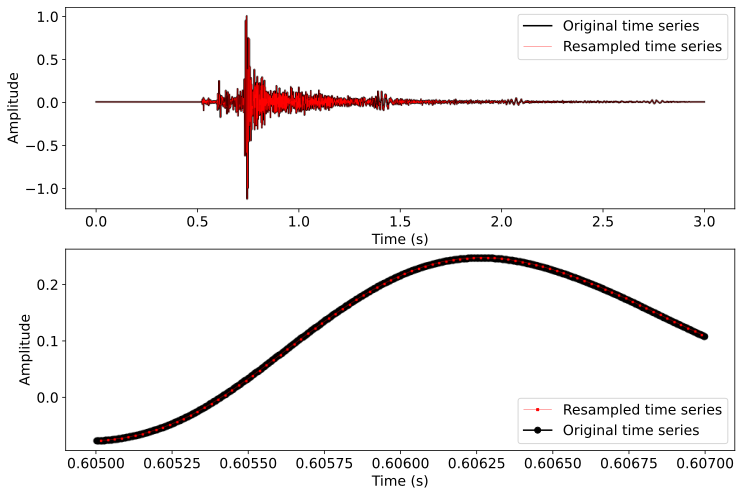

In [27]:
# RESAMPLING
fs_resample = 44100 # target sampling frequency in Hz
data_n_rs = resampy.resample(data_n, fs_sound, fs_resample)

time = np.linspace(0., len(data_n)/fs_sound, len(data_n))
time_resample = np.linspace(0., len(data_n)/fs_sound, len(data_n_rs))
print(len(time), len(time_resample))
# plot some to test... replot by sound time...
start = 1000
end = 1000 + 100
fig, axes = plt.subplots(num="waveforms", nrows=2, figsize=(12, 8))
axes[0].plot(time, data_n, "k-", label="Original time series", rasterized=True)  # [start:end]
axes[0].plot(time_resample, data_n_rs, "r-", label="Resampled time series", lw=0.33, rasterized=True)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")
axes[0].legend(loc="upper right")

time_min = 0.6050
time_max = 0.6070

selection1 = (time > time_min) & (time < time_max)
selection2 = (time_resample > time_min) & (time_resample < time_max)
axes[1].plot(time_resample[selection2], data_n_rs[selection2], "r-", label="Resampled time series", marker="s", markersize=2, lw=0.33, rasterized=True)
axes[1].plot(time[selection1], data_n[selection1], "k-", label="Original time series", marker="o", zorder=0, rasterized=True)  # [start:end]
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend(loc="lower right")


print(f"We are generating a sound with sampling frequency fs={fs_resample:.0f}Hz.")

ipd.Audio(data_n_rs, rate=fs_resample)


In [28]:
# write the sound to a .wav file:

outfile_name = f"Tohoku2011_sound_sf{SpeedFactor:.0f}_rs441.wav"
out = os.path.join(DirOut, outfile_name)
print(f"The path to the sonified Tohoku-oki earthquake will be: {out}")
# write(out, fs_sound, data_n.astype(np.int16))
write(out, 44100, data_n_rs.astype(np.float32))


The path to the sonified Tohoku-oki earthquake will be: ../output_nogit/Tohoku2011_sound_sf16800_rs441.wav


# =========================================================
# Example 2: Much longer seismic signal: free oscillations 
### filtering to find a hidden signal ! 

#### Their period typically ranges from 20 minutes to a few hours, i.e. a frequency between, say, approximately 0.0002 and 0.002 Hz

### https://vimeo.com/215665951
### http://lucien.saviot.free.fr/terre/index.en.html 

In [29]:
# get the data in:
DirIn = os.path.join(os.pardir, "data_nogit", "seismic_data")

# This is the Sumatra earthquake (2004), recorded by a seimic station located in Albuquerque, NM
FileNameIn = "Sumatra_2004_ANMO_14wks.VHZ"
# Note that this data has been pre-processed (instrument response removal)
fs = 0.1
# Datatype VHZ is downsampled to 0.1 Hz (p=10 s)

data = np.loadtxt(os.path.join(DirIn, FileNameIn))
N_samps = len(data)
duration = N_samps / fs


In [30]:
# make time vectors for plotting purposes only
t = np.arange(0, duration, 1.0 / fs)  # in seconds
t_hours = np.arange(0, duration / 3600, 1.0 / fs / 3600)  # in hours
t_days = np.arange(0, duration / 3600 / 24, 1.0 / fs / 3600 / 24)  # in days

print(f"We have {N_samps} samples at {fs} samples/second.")
print(f"We have {duration:.0f} seconds of data.")
print(f"... which is {duration / 3600.:.1f} hours,")
print(f"... which is {duration / (24. * 3600):.1f} days.")


We have 846720 samples at 0.1 samples/second.
We have 8467200 seconds of data.
... which is 2352.0 hours,
... which is 98.0 days.


In [31]:
# Compute the spectrum
S = spfft.rfft(data, len(data))
f = spfft.rfftfreq(len(data), d=1./fs)

print(f"Frequency content ranges from {f[0]:.0f}Hz to {f[-1]:.3f}Hz...")
print(f"or, in log scale, {np.log10(f[1]):.2f}[log10(Hz)] to {np.log10(f[-1]):.2f}[log10(Hz)]")

Frequency content ranges from 0Hz to 0.050Hz...
or, in log scale, -6.93[log10(Hz)] to -1.30[log10(Hz)]


In [32]:
# 1) force the signal's mean value to be zero (how to kill your loudspeakers...)
data = data - np.mean(data)

# 2) limit the signal's amplitude = avoid too large peaks (how to re-kill your loudspeakers...)
# but keep the value because we want to compare the power to other data...
data_n = data / np.amax(data)


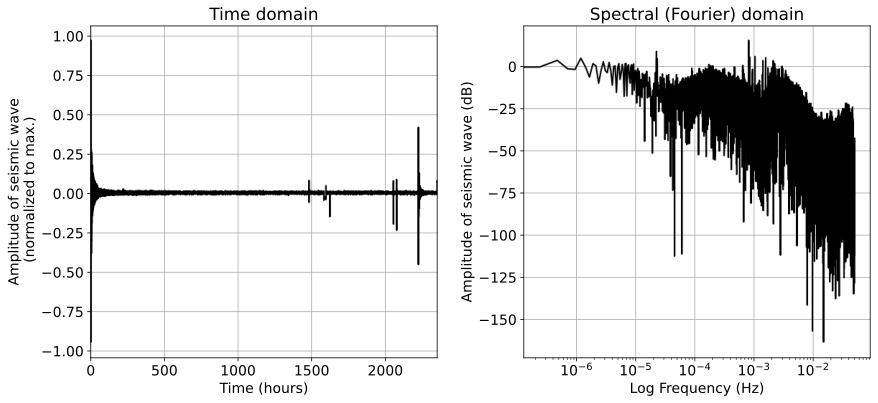

In [33]:
# plot
fig, axes = plt.subplots(num="time_vs_spectral_domain", figsize=(14, 6), ncols=2)

# set the following variable to 1 to remove decimation, decimation helps plot faster
decimation_for_plot = 4

axes[0].set_title("Time domain")
axes[0].plot(t_hours[::decimation_for_plot], data_n[::decimation_for_plot], "k", rasterized=True)
axes[0].set_xlabel("Time (hours)")
axes[0].set_ylabel("Amplitude of seismic wave\n (normalized to max.)")
axes[0].grid()
axes[0].set_xlim([0, duration / 3600])

axes[1].set_title("Spectral (Fourier) domain")
axes[1].plot(f[::decimation_for_plot], 20 * np.log10(np.abs(S))[::decimation_for_plot], "k", rasterized=True)
axes[1].set_xlabel("Log Frequency (Hz)")
axes[1].set_ylabel("Amplitude of seismic wave (dB)")
axes[1].semilogx()
axes[1].grid()

plt.subplots_adjust(wspace=0.25)

(0.0002, 0.002)

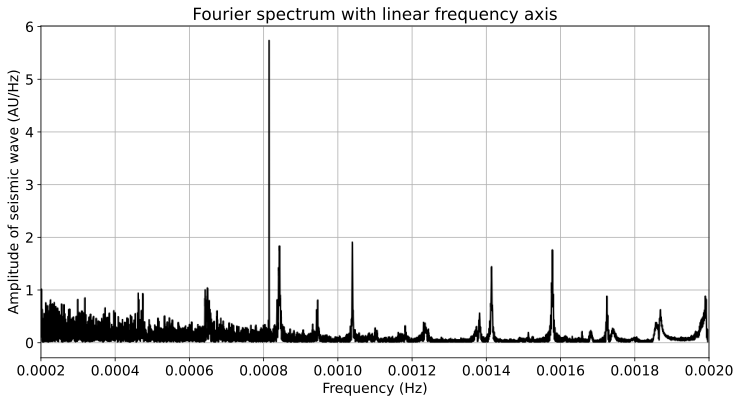

In [34]:
decimation_for_plot = 4

fig, ax = plt.subplots(num="spectrum_linear_freq", figsize=(12, 6))
ax.set_title("Fourier spectrum with linear frequency axis")
# plt.plot(np.log10(f),np.log10(np.absolute(S)),'k')
ax.plot(f[::decimation_for_plot], np.abs(S[::decimation_for_plot]), "k", rasterized=True)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude of seismic wave (AU/Hz)")
ax.grid()
ax.set_xlim([0.0002, 0.002])


In [35]:
# SPECTROGRAM !
# first compute the short time fourier transform STFT
# "Uncertainty Principle": there is a direct tradeoff between resolution in frequency and in time:
# that is governed by the window length NfftSTFT

# for the full signal spectra, the Nfft (number of frequencies was simply the length of the signal.
# instead calculate Nfft upward from the sampling frequency and then window time?
#
WindowDur = 300  # in seconds (can calculate this from the lower end of the frequency spectrum that you want to resolve too)
# or
duration = len(data) / fs
numwindows = 100
WindowDur = duration / numwindows


WindowLength = int(
    WindowDur * fs
)  # [s] The length of each frame (should be expressed in samples)
# does this need to be a power of 2 ?  apparently not ! (it could be to make it faster)

print(f"Window duration in seconds: {WindowDur:.2f}sec.")
print(f"Window length in samples: {WindowLength:d}spl.")

# Window overlap: The overlapping between successive frames (should be expressed in samples)
# This changes the total number of windows, but has to be smaller than the window length (in samples)
# Eric says the optimal is the number of points - 1 ! (not necessarily, I just said that for the specific application with SpecUFEX)
# Overlap = int(WindowLength/2)  # 50% overlap:  quick but has some aliasing/artifacts
# Overlap = int(WindowLength-1)  # length - 1 !  TOO much for this machine!
Overlap = int(0.5 * WindowLength)

[fSTFT, tSTFT, STFT] = spsig.spectrogram(
    data_n, fs, nperseg=WindowLength, noverlap=Overlap,# nfft=NfftSTFT
)
# also provides associated f and t vectors!
print(f"The frequency axis has {len(fSTFT):d} elements, ranging from {fSTFT.min():.2e}Hz to {fSTFT.max():.2f}Hz.")
print(f"The time axis has {len(tSTFT):d} elements, ranging from {tSTFT.min()}s to {tSTFT.max()}s.")
print(f"The shape of the STFT matrix is: {STFT.shape}")


Window duration in seconds: 84672.00sec.
Window length in samples: 8467spl.
The frequency axis has 4234 elements, ranging from 0.00e+00Hz to 0.05Hz.
The time axis has 198 elements, ranging from 42335.0s to 8383315.0s.
The shape of the STFT matrix is: (4234, 198)


In [36]:
outfile_name = "14weeks_Sumatra_nofilt.wav"

OriginalDuration = duration
TargetDuration = 24.0  # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print(f"The data is {OriginalDuration:.0f}-second long.")
print(f"Let's make a {TargetDuration:.0f}-second long sound!")

SpeedFactor = OriginalDuration / TargetDuration
print(f"This corresponds to a speed factor of: {SpeedFactor:.0f}.")

# So, set the new sampling rate, and then resample to a standard sampling rate
fs_sound = int(fs * SpeedFactor)
# resample at 44.100 kHz
fs_resample = 44100
data_rs = resampy.resample(data_n, fs_sound, fs_resample)
# librosa.output.write_wav(DirOut + outfile_name, data_rs, sr_resample, norm=False)

# Some software have troubles with exotic sampling rates (VLC and audacity don't have), so it might be necessary
# to resample your sound. if so, uncomment:

# fs_resample = 44100
# dataOrig, srOrig = librosa.core.load(DirOut + OutFileName, sr=fs_sound)
# data_rs = resampy.resample(dataOrig, srOrig, fs_resample)
# librosa.output.write_wav(DirOut + OutFileName, data_rs, fs_resample, norm=False)


The data is 8467200-second long.
Let's make a 24-second long sound!
This corresponds to a speed factor of: 352800.


In [37]:
ipd.Audio(data_rs, rate=fs_resample) 

(0.0002, 0.002)

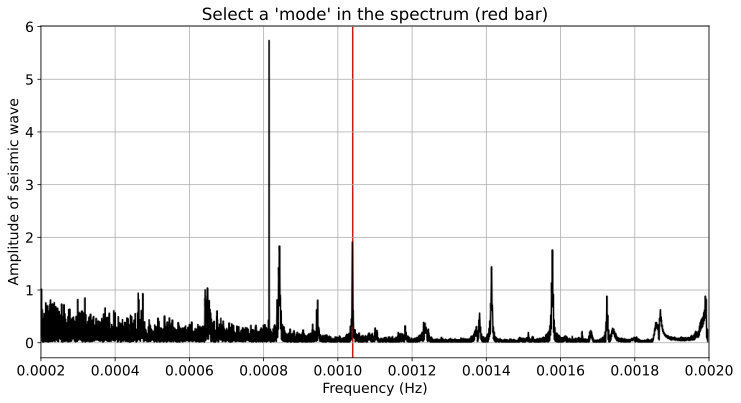

In [38]:
# FILTER AROUND THE MODES !

# fcenter = 0.000833333
fcenter = 0.00104 # in Hz
# fcenter = 1/(36*60)

decimation_for_plot = 4

fig, ax = plt.subplots(num="Sumatra_selected_frequency", figsize=(12, 6))
ax.set_title("Select a 'mode' in the spectrum (red bar)")
ax.plot(f[::decimation_for_plot], np.abs(S)[::decimation_for_plot], "k", rasterized=True)
ax.axvline(fcenter, color="r", zorder=0)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude of seismic wave")
ax.grid()
ax.set_xlim([0.0002, 0.002])


In [39]:
Q = 5  # Quality factor: how wide the filter is around fcenter (higher value damps LESS quickly)
FiltOrder = 2
# Filter Order: (how steep the sides are)


BW_SemiWidth = fcenter / (2 * Q)
fmin = fcenter - BW_SemiWidth
fmax = fcenter + BW_SemiWidth
cutofffreq = np.array([fmin, fmax]) / (fs / 2)

b, a = spsig.butter(FiltOrder, cutofffreq, btype="band", analog=False, output="ba")
w, h = spsig.freqz(b, a)
w = w * fs / np.pi / 2

data_filt = spsig.lfilter(b, a, data)
S_filt = spfft.rfft(data_filt, len(data_filt))  # compute the spectrum

print(f"Center frequency is: {fcenter:.2e} Hz")
print(f"Cutoff frequencies are: {fmin:.2e}Hz and {fmax:.2e}Hz.")


Center frequency is: 1.04e-03 Hz
Cutoff frequencies are: 9.36e-04Hz and 1.14e-03Hz.


/tmp/ipykernel_18565/2403094414.py:27: RuntimeWarning: divide by zero encountered in log10
  20 * np.log10(abs(h)) + +20 * np.log10(np.amax(np.abs(S))),
/tmp/ipykernel_18565/2403094414.py:44: RuntimeWarning: divide by zero encountered in log10
  20 * np.log10(abs(h)) + 20 * np.log10(np.amax(np.abs(S_filt))),
/tmp/ipykernel_18565/2403094414.py:61: RuntimeWarning: divide by zero encountered in log10
  20 * np.log10(abs(h)) + 20 * np.log10(np.amax(np.abs(S_filt))),


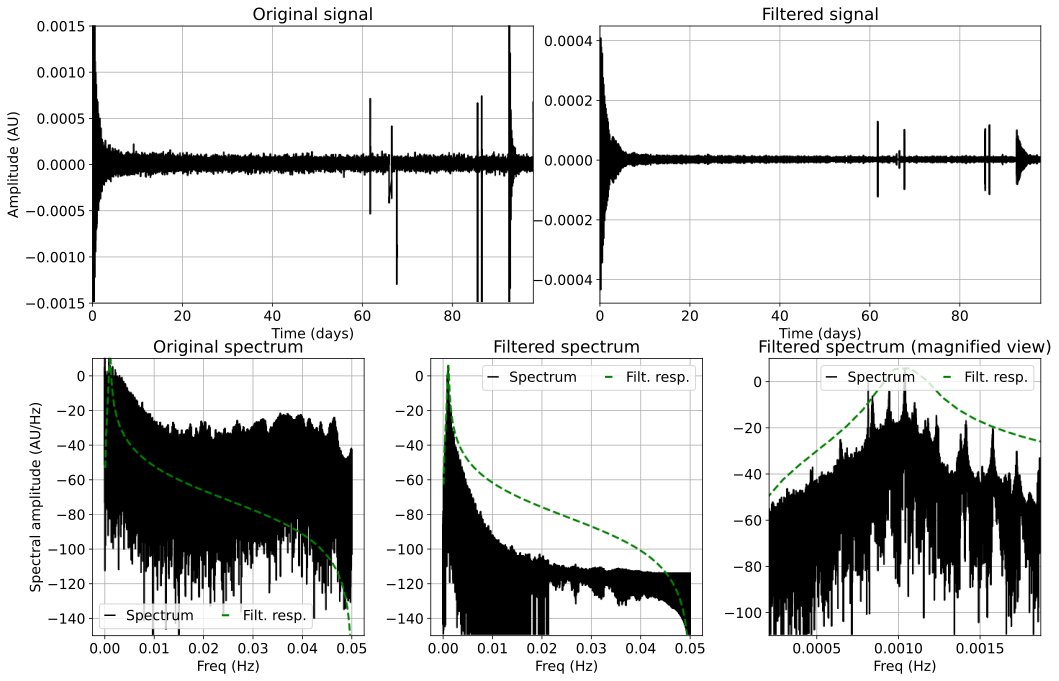

In [40]:
##### Plot and compare original and filtered signals
fig = plt.figure("Sumatra_original_vs_filtered", figsize=(17, 11))
gs = fig.add_gridspec(2, 6)


ax1 = fig.add_subplot(gs[0, :3])
ax1.plot(t_days, data, "k", rasterized=True)
ax1.set_title("Original signal")
ax1.set_xlabel("Time (days)")
ax1.set_ylim([-0.0015, 0.0015])
ax1.grid()
ax1.set_xlim([0, duration / 3600 / 24])
ax1.set_ylabel("Amplitude (AU)")

ax2 = fig.add_subplot(gs[0, 3:])
ax2.plot(t_days, data_filt, "k", rasterized=True)
ax2.set_title("Filtered signal")
ax2.set_xlabel("Time (days)")
ax2.grid()
ax2.set_xlim([0, duration / 3600 / 24])


ax3 = fig.add_subplot(gs[1, :2])
ax3.plot(f, 20 * np.log10(np.abs(S)), "k", label="Spectrum", rasterized=True)
ax3.plot(
    w,
    20 * np.log10(abs(h)) + +20 * np.log10(np.amax(np.abs(S))),
    "--g",
    label="Filt. resp.",
    linewidth=2,
    rasterized=True,
)
ax3.set_title("Original spectrum")
ax3.set_xlabel("Freq (Hz)")
ax3.set_ylim([-150.0, 10.0])
ax3.grid()
ax3.legend(loc="lower left", ncol=2, handlelength=0.7)
ax3.set_ylabel("Spectral amplitude (AU/Hz)")

ax4 = fig.add_subplot(gs[1, 2:4])
ax4.plot(f, 20 * np.log10(np.abs(S_filt)), "k", label="Spectrum", rasterized=True)
ax4.plot(
    w,
    20 * np.log10(abs(h)) + 20 * np.log10(np.amax(np.abs(S_filt))),
    "--g",
    label="Filt. resp.",
    linewidth=2,
    rasterized=True,
)
ax4.set_title("Filtered spectrum")
ax4.set_xlabel("Freq (Hz)")
ax4.set_ylim([-150.0, 10.0])
ax4.grid()
ax4.legend(loc="upper right", ncol=2, handlelength=0.7)


ax5 = fig.add_subplot(gs[1, 4:])
ax5.plot(f, 20 * np.log10(np.abs(S_filt)), "k", label="Spectrum", rasterized=True)
ax5.plot(
    w,
    20 * np.log10(abs(h)) + 20 * np.log10(np.amax(np.abs(S_filt))),
    "--g",
    label="Filt. resp.",
    linewidth=2,
    rasterized=True,
)
ax5.set_xlim([fcenter - 8 * BW_SemiWidth, fcenter + 8 * BW_SemiWidth])
ax5.set_title("Filtered spectrum (magnified view)")
ax5.set_xlabel("Freq (Hz)")
ax5.set_ylim([-110.0, 10.0])
ax5.grid()
ax5.legend(loc="upper right", ncol=2, handlelength=0.7)

plt.subplots_adjust(wspace=0.65)
# want to save this awesome figure?
# fig.savefig(DirOut + 'SumatraFiltered.png')


In [41]:
# SPECTROGRAM !

duration = len(data_filt) / fs
numwindows = 100
WindowDur = duration / numwindows


WindowLength = int(
    WindowDur * fs
)  # [s] The length of each frame (should be expressed in samples)
# does this need to be a power of 2 ?  apparently not ! (it could be to make it faster)

print(f"Window duration in seconds: {WindowDur:.2f}sec.")
print(f"Window length in samples: {WindowLength:d}spl.")

# probably no need to change this. 
Overlap = int(0.5 * WindowLength) # The overlapping between successive frames (should be expressed in samples)

[fSTFT, tSTFT, STFT] = spsig.spectrogram(
    data_filt, fs, nperseg=WindowLength, noverlap=Overlap
    ) 
# also provides associated f and t vectors!
print(f"The frequency axis has {len(fSTFT):d} elements, ranging from {fSTFT.min():.2e}Hz to {fSTFT.max():.2f}Hz.")
print(f"The time axis has {len(tSTFT):d} elements, ranging from {tSTFT.min()}s to {tSTFT.max()}s.")
print(f"The shape of the STFT matrix is: {STFT.shape}")

Window duration in seconds: 84672.00sec.
Window length in samples: 8467spl.
The frequency axis has 4234 elements, ranging from 0.00e+00Hz to 0.05Hz.
The time axis has 198 elements, ranging from 42335.0s to 8383315.0s.
The shape of the STFT matrix is: (4234, 198)


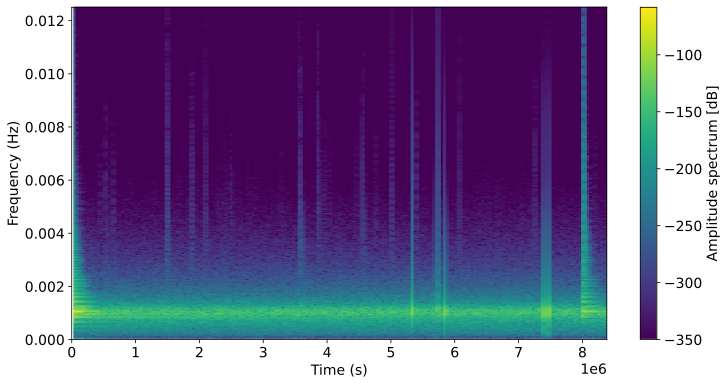

In [42]:
# Let's plot the spectrogram
# notice that the y-axis goes up to half of fs ! i.e. Nyquist frequency
fig, ax = plt.subplots(figsize=(12, 6))
pc = ax.pcolormesh(
    tSTFT, fSTFT, 20 * np.log10(np.abs(STFT)), rasterized=True, vmin=-350
)  # dB = 20*log() is a convention
ax.set_ylim([0, fs/8])
ax.set_xlim([0, duration - WindowLength / fs])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
cbar = plt.colorbar(pc, label="Amplitude spectrum [dB]")
# try with frequency in log scale:
# ax.semilogy()
# ax.set_ylim(0.001, 10.)


In [43]:
# MAKE THE FILTERED SOUND !

outfile_name = "14weeks_Sumatra_filt00104.wav"


OriginalDuration = duration
TargetDuration = 14.0  # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print(f"The data is {OriginalDuration:.0f}-second long.")
print(f"Let's make a {TargetDuration:.0f}-second long sound!")

SpeedFactor = OriginalDuration / TargetDuration
print(f"This corresponds to a speed factor of: {SpeedFactor:.0f}.")

# So, set the new sampling rate, and then resample to a standard sampling rate
fs_sound = int(fs * SpeedFactor)
# resample at 44.100 kHz
fs_resample = 44100
data_rs = resampy.resample(data_n, fs_sound, fs_resample)
# librosa.output.write_wav(DirOut + outfile_name, data_rs, sr_resample, norm=False)

ipd.Audio(data_rs, rate=fs_resample)


The data is 8467200-second long.
Let's make a 14-second long sound!
This corresponds to a speed factor of: 604800.


## EXERCISE: Go back and filter it on different modes, 
### play with the speed factor and build a composite sound of several modes, using Audacity, or adding waveforms to each other.   

# =========================================================
# Example 3: LIGO data   
## Laser Interferometer Gravitational-Wave Observatory  (DOI: 10.1103/PhysRevLett.116.061102)
## https://www.ligo.org/
### Much, much much lower amplitude than seismic waves: compare the spectra !
### (too short for direct sonification !)  

In [44]:
# get the data in:
DirIn = os.path.join(os.pardir, "data", "LIGO")

# This is the Sumatra earthquake (2004), recorded by a seimic station located in Albuquerque, NM
FileNameIn = "obs_HanfordWA.txt"
# https://www.gw-openscience.org/GWTC-1-confident/

data = np.loadtxt(os.path.join(DirIn, FileNameIn))
print(data.shape)
print(data[0, 0])
# note that np.loadtext automatically skipped the column headers !

time = np.squeeze(data[0:-1, 0])
strain = np.squeeze(data[0:-1, 1])
print(time.shape)

print(time[-1])
# plt.plot(time-time[0])

duration0 = time[-1] - time[0]
dt = duration0 / len(
    time
)  # since we don't a priori know if time is regularly spaced (probably is)
print(duration0)

fs = 1 / dt
print(fs)

# duration = len(data)/fs
# print(duration)


(3441, 2)
0.25
(3440,)
0.45989990234375
0.20989990234375
16388.764175632452


In [45]:
# play it directly ! 
data = strain 

# Compute the spectrum
S = spfft.rfft(data, len(data)) 
f = spfft.rfftfreq(len(data), d=1./fs)

print(len(f))
print(len(S))

print(f"Frequency content ranges from {f[0]:.2e}Hz to {f[-1]:.2f}Hz... (Nyquist frequency)")
print(f"Log frequency content ranges from {np.log10(f[1]):.2f}[log10(Hz)] to {np.log10(f[-1]):.2f}[log10(Hz)]")

3440
3440
Frequency content ranges from 0.00e+00Hz to 8194.38Hz... (Nyquist frequency)
Log frequency content ranges from 0.68[log10(Hz)] to 3.91[log10(Hz)]


[]

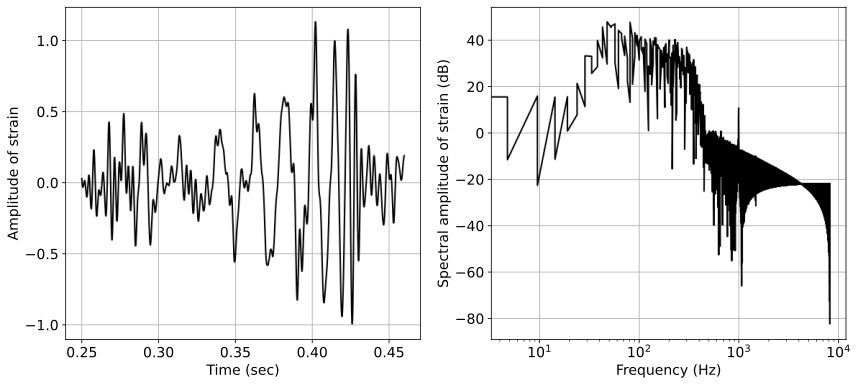

In [46]:
fig, axes = plt.subplots(num="Ligo_time_vs_spectral", ncols=2, figsize=(14, 6))

axes[0].plot(time, data, "k", rasterized=True)
axes[0].set_xlabel("Time (sec)")
axes[0].set_ylabel("Amplitude of strain")
axes[0].grid()

axes[1].plot(f, 20 * np.log10(np.abs(S)), "k", rasterized=True)
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Spectral amplitude of strain (dB)")
# axes[1].set_xlim([0.01, 1])
axes[1].grid()
axes[1].semilogx()


In [47]:
# SPECTROGRAM !
duration = len(data) / fs
numwindows = 20
WindowDur = duration / numwindows


WindowLength = int(
    WindowDur * fs
)  # [s] The length of each frame (should be expressed in samples)
# does this need to be a power of 2 ?  apparently not ! (it could be to make it faster)

print(f"Window duration in seconds: {WindowDur:.2f}sec.")
print(f"Window length in samples: {WindowLength:d}spl.")

# Window overlap: The overlapping between successive frames (should be expressed in samples)
# This changes the total number of windows, but has to be smaller than the window length (in samples)
# Eric says the optimal is the number of points - 1 ! (not necessarily, I just said that for the specific application with SpecUFEX)
# Overlap = int(WindowLength/2)  # 50% overlap:  quick but has some aliasing/artifacts
# Overlap = int(WindowLength-1)  # length - 1 !  TOO much for this machine!
Overlap = int(0.75 * WindowLength)

[fSTFT, tSTFT, STFT] = spsig.spectrogram(
    data, fs, nperseg=WindowLength, noverlap=Overlap,# nfft=NfftSTFT
)
# also provides associated f and t vectors!
print(f"The frequency axis has {len(fSTFT):d} elements, ranging from {fSTFT.min():.2e}Hz to {fSTFT.max():.2f}Hz.")
print(f"The time axis has {len(tSTFT):d} elements, ranging from {tSTFT.min()}s to {tSTFT.max()}s.")
print(f"The shape of the STFT matrix is: {STFT.shape}")

Window duration in seconds: 0.01sec.
Window length in samples: 172spl.
The frequency axis has 87 elements, ranging from 0.00e+00Hz to 8194.38Hz.
The time axis has 77 elements, ranging from 0.00524749755859375s to 0.20465240478515626s.
The shape of the STFT matrix is: (87, 77)


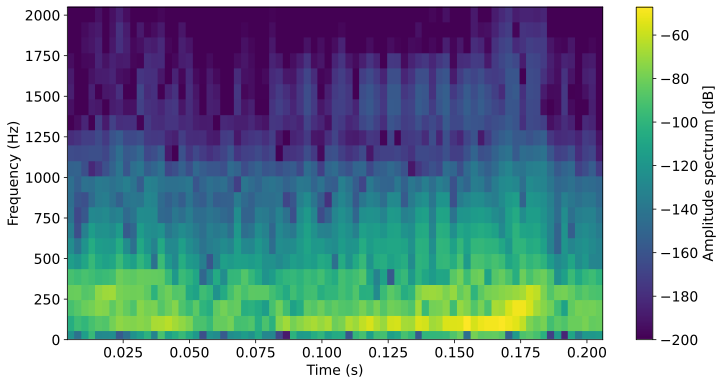

In [48]:
# Let's plot the spectrogram
# notice that the y-axis goes up to half of fs ! i.e. Nyquist frequency
fig, ax = plt.subplots(figsize=(12, 6))
pc = ax.pcolormesh(
    tSTFT, fSTFT, 20 * np.log10(np.absolute(STFT)), rasterized=True, vmin=-200
)  # dB = 20*log() is a convention
ax.set_ylim([0, fs / 8])
# ax.set_xlim([0,dur1-SliceLength/sr])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
cbar = plt.colorbar(pc, label="Amplitude spectrum [dB]")
# try with frequency in log scale:
# ax.semilogy()
# ax.set_ylim(0.001, 10.)


In [49]:
# MAKE THE FILTERED SOUND !

outfile_name = "LIGO_WA_nofilt.wav"

OriginalDuration = duration
TargetDuration = (
    10.0 * duration
)  # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print(f"The data is {OriginalDuration:.3f}-second long.")
print(f"Let's make a {TargetDuration:.3f}-second long sound!")

SpeedFactor = OriginalDuration / TargetDuration
print(f"This corresponds to a speed factor of: {SpeedFactor:.2f}.")

# So, set the new sampling rate, and then resample to a standard sampling rate
fs_sound = int(fs * SpeedFactor)
# resample at 44.100 kHz
fs_resample = 44100
data_rs = resampy.resample(data, fs_sound, fs_resample)
# librosa.output.write_wav(DirOut + outfile_name, data_rs, sr_resample, norm=False)

ipd.Audio(data_rs, rate=fs_resample)


The data is 0.210-second long.
Let's make a 2.099-second long sound!
This corresponds to a speed factor of: 0.10.


## There is not enough data for direct sonification ! 
## We must use other means !  Future notebooks ! 